# **Import Libraries** 

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import os
import torch
from tensorflow.keras.models import Sequential
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.image as mpimg
from tensorflow.keras.regularizers  import L2, L1
import cv2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers import LSTM, Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy

# **Access Data**

In [10]:
dataset_path = r'/kaggle/input/thesis-2/CASIA2'

# **All Types of Image Extensions**

In [11]:
def get_image_extensions(dataset_path):
    extensions = set()
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            # Get the file extension
            extension = os.path.splitext(file)[1]
            # Add the extension to the set
            extensions.add(extension.lower()) 
    return extensions

In [12]:
image_extensions = get_image_extensions(dataset_path)
print("Image extensions in the dataset:")
for extension in image_extensions:
    print(extension)

Image extensions in the dataset:
.tif
.jpg
.bmp


# **Unique Channels**

In [5]:
dataset_dir = dataset_path

unique_channels = set()

for folder_type in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder_type)

    if not os.path.isdir(folder_path):
        continue

    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)

        if not os.path.isdir(label_path):
            continue

        for filename in os.listdir(label_path):
            img = mpimg.imread(os.path.join(label_path, filename))
            channels = img.shape[2]
            unique_channels.add(channels)

print("Unique channels:", unique_channels)

Unique channels: {3, 4}


# **Image Padding**

In [13]:
new_image_width = 224
new_image_height = 224

def pad_image(img):
    color = (0, 0, 0)
    result = np.full((new_image_height, new_image_width, 3), color, dtype=np.uint8)

    x_offset = (new_image_width - img.shape[1]) // 2
    y_offset = (new_image_height - img.shape[0]) // 2

    result[y_offset:y_offset+img.shape[0], x_offset:x_offset+img.shape[1]] = img

    return result

# **Resize Images**

In [14]:
def resize_image(img):

    if img.shape[1] > new_image_width or img.shape[0] > new_image_height:

        scale_factor = min(new_image_width / img.shape[1], new_image_height / img.shape[0])
        img = cv2.resize(img, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

    return img

# **Feature Scaling**

In [15]:
def load_dataset(dataset_path):
    images = []
    valid_extensions = {'.jpg', '.jpeg', '.tif', '.tiff'}

    total_images = sum(len(files) for _, _, files in os.walk(dataset_path))
    pbar = tqdm(total=total_images, desc="Loading images", unit="image")

    for folder_type in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder_type)
        if not os.path.isdir(folder_path):
            continue

        for label in os.listdir(folder_path):
            label_path = os.path.join(folder_path, label)
            if not os.path.isdir(label_path):
                continue

            for filename in os.listdir(label_path):
                image_path = os.path.join(label_path, filename)
                _, file_extension = os.path.splitext(filename)
                if file_extension.lower() not in valid_extensions:
                    continue

                img = cv2.imread(image_path)
                if img.shape[2] == 4:  # Skip images with 4 channels
                    continue

                img = resize_image(img)
                padded_img = pad_image(img)
                normalized_img = padded_img.astype(np.float32) / 255.0

                images.append(normalized_img)
                pbar.update(1)
    pbar.close()
    return np.array(images)

# **Apply all functions from above to the dataset.**  

In [16]:
images = load_dataset(dataset_path)
print("Shape of the loaded dataset:", images.shape)

Loading images: 100%|█████████▉| 12558/12612 [03:39<00:00, 57.32image/s]


Shape of the loaded dataset: (12558, 224, 224, 3)


# **Convert Numpy to Tensor**
- tensor data type is computetional resource optimized then numpy data type.

In [17]:
images = torch.tensor(images)

# Create Label Data
- in the dataset fake images are in "Fake" folder and real images are in "Real" folder. 
- so here we labeled images as 1 when an image is in the Fake folder. if the image is in the Real folder then we labeled it to 0  

In [18]:
def load_dataset(dataset_path):
    labels = []
    valid_extensions = {'.jpg', '.jpeg', '.tif', '.tiff'}
    
    total_images = sum(len(files) for _, _, files in os.walk(dataset_path))
    
    pbar = tqdm(total=total_images, desc="Loading images", unit="image")

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            for subfolder in os.listdir(folder_path):
                subfolder_path = os.path.join(folder_path, subfolder)
                if os.path.isdir(subfolder_path):
                    label = 1 if subfolder == 'Fake' else 0 
                    for filename in os.listdir(subfolder_path):
                        image_path = os.path.join(subfolder_path, filename)
                        # Check if the file extension is valid
                        _, file_extension = os.path.splitext(filename)
                        if file_extension.lower() in valid_extensions:
                            try:
                                labels.append(label)
                            except (OSError, IsADirectoryError):
                                print("Skipping file:", image_path)
                                continue
                        pbar.update(1)
    pbar.close()
    return np.array(labels)
labels = load_dataset(dataset_path)

Loading images: 100%|██████████| 12612/12612 [00:00<00:00, 144721.39image/s]


# **Here is our data after preprocessing**

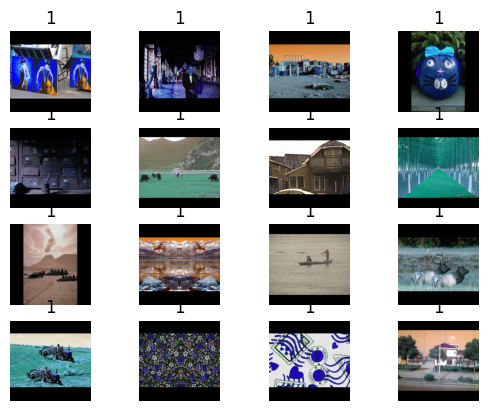

In [15]:
for i, (image, label) in enumerate(zip(images[:16], labels[:16])):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(str(label))
    plt.axis('off')

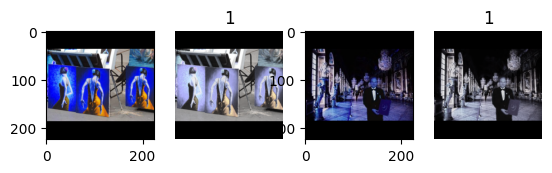

In [16]:
for i, (image, label) in enumerate(zip(images[:2], labels[:2])):
    plt.subplot(1, 4, 2*i + 1)
    plt.imshow(image)

    plt.subplot(1, 4, 2*i + 2)
    plt.imshow(tf.image.adjust_saturation(image, 0.3))


    plt.title(str(label))
    plt.axis('off')

In [17]:
for i in range(4):
    image = images[i] 
    label = labels[i] 
    print(torch.max(image))

tensor(1.)
tensor(0.9882)
tensor(0.9686)
tensor(1.)


In [18]:
print(len(images))
print(type(images))

12558
<class 'torch.Tensor'>


In [19]:
print(len(labels))
print(type(labels))

12558
<class 'numpy.ndarray'>


# **Data Splitting**

In [19]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Numpy to Tensor Conversion (Output Feature)

In [20]:
X_train_tf = tf.convert_to_tensor(X_train)
y_train_tf = tf.convert_to_tensor(y_train)
X_test_tf = tf.convert_to_tensor(X_test)
y_test_tf = tf.convert_to_tensor(y_test)

# Convert RGB Images to Gray Scale

In [21]:
def rgb_to_grayscale_tensorflow(images):
    grayscale_images = tf.image.rgb_to_grayscale(images)
    return grayscale_images

In [22]:
X_train_gray_tf = rgb_to_grayscale_tensorflow(X_train_tf)
print("Shape of X_train_gray_tf:", X_train_gray_tf.shape)

Shape of X_train_gray_tf: (10046, 224, 224, 1)


In [23]:
X_test_gray_tf = rgb_to_grayscale_tensorflow(X_test_tf)
print("Shape of X_test_gray_tf:", X_test_gray_tf.shape)

Shape of X_test_gray_tf: (2512, 224, 224, 1)


In [22]:
y_train_tf.shape, y_test_tf.shape

(TensorShape([10046]), TensorShape([2512]))

# **Propsed Model**

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, LSTM, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2

In [28]:
LEARNING_RATE =  0.001
# Define your LeNet model for grayscale images (ConvNet part)
IM_SIZE = 224
N_FILTERS = 6
KERNEL_SIZE = 3
N_STRIDES = 1
POOL_SIZE = 2
N_DENSE_1 = 100
N_DENSE_2 = 10
DROPOUT_RATE = 0.0
REGULARIZATION_RATE = 0.0

input_layer = Input(shape=(IM_SIZE, IM_SIZE, 1))

x = Conv2D(filters=N_FILTERS, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE))(input_layer)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=POOL_SIZE, strides=(2, 2))(x)
x = Dropout(rate=DROPOUT_RATE)(x)

x = Conv2D(filters=N_FILTERS*2, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE))(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=POOL_SIZE, strides=(2, 2))(x)

x = Flatten()(x)

x = Dense(N_DENSE_1, activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE))(x)
x = BatchNormalization()(x)
x = Dropout(rate=DROPOUT_RATE)(x)

x = Dense(N_DENSE_2, activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE))(x)
x = BatchNormalization()(x)

# Reshape the output to match the LSTM input shape
x = Reshape((N_DENSE_2, 1))(x)

# LSTM part
lstm_output = LSTM(units=100)(x)

output_layer = Dense(1, activation='sigmoid')(lstm_output)

# Create the hybrid model
hybrid_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Print model summary to verify the architecture
hybrid_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 6)    │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 12)   │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 109, 109, 12)   │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 34992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │     3,499,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,542,443 (13.51 MB)

 Trainable params: 3,542,187 (13.51 MB)

 Non-trainable params: 256 (1.00 KB)

In [4]:
!pip install pydot graphviz

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


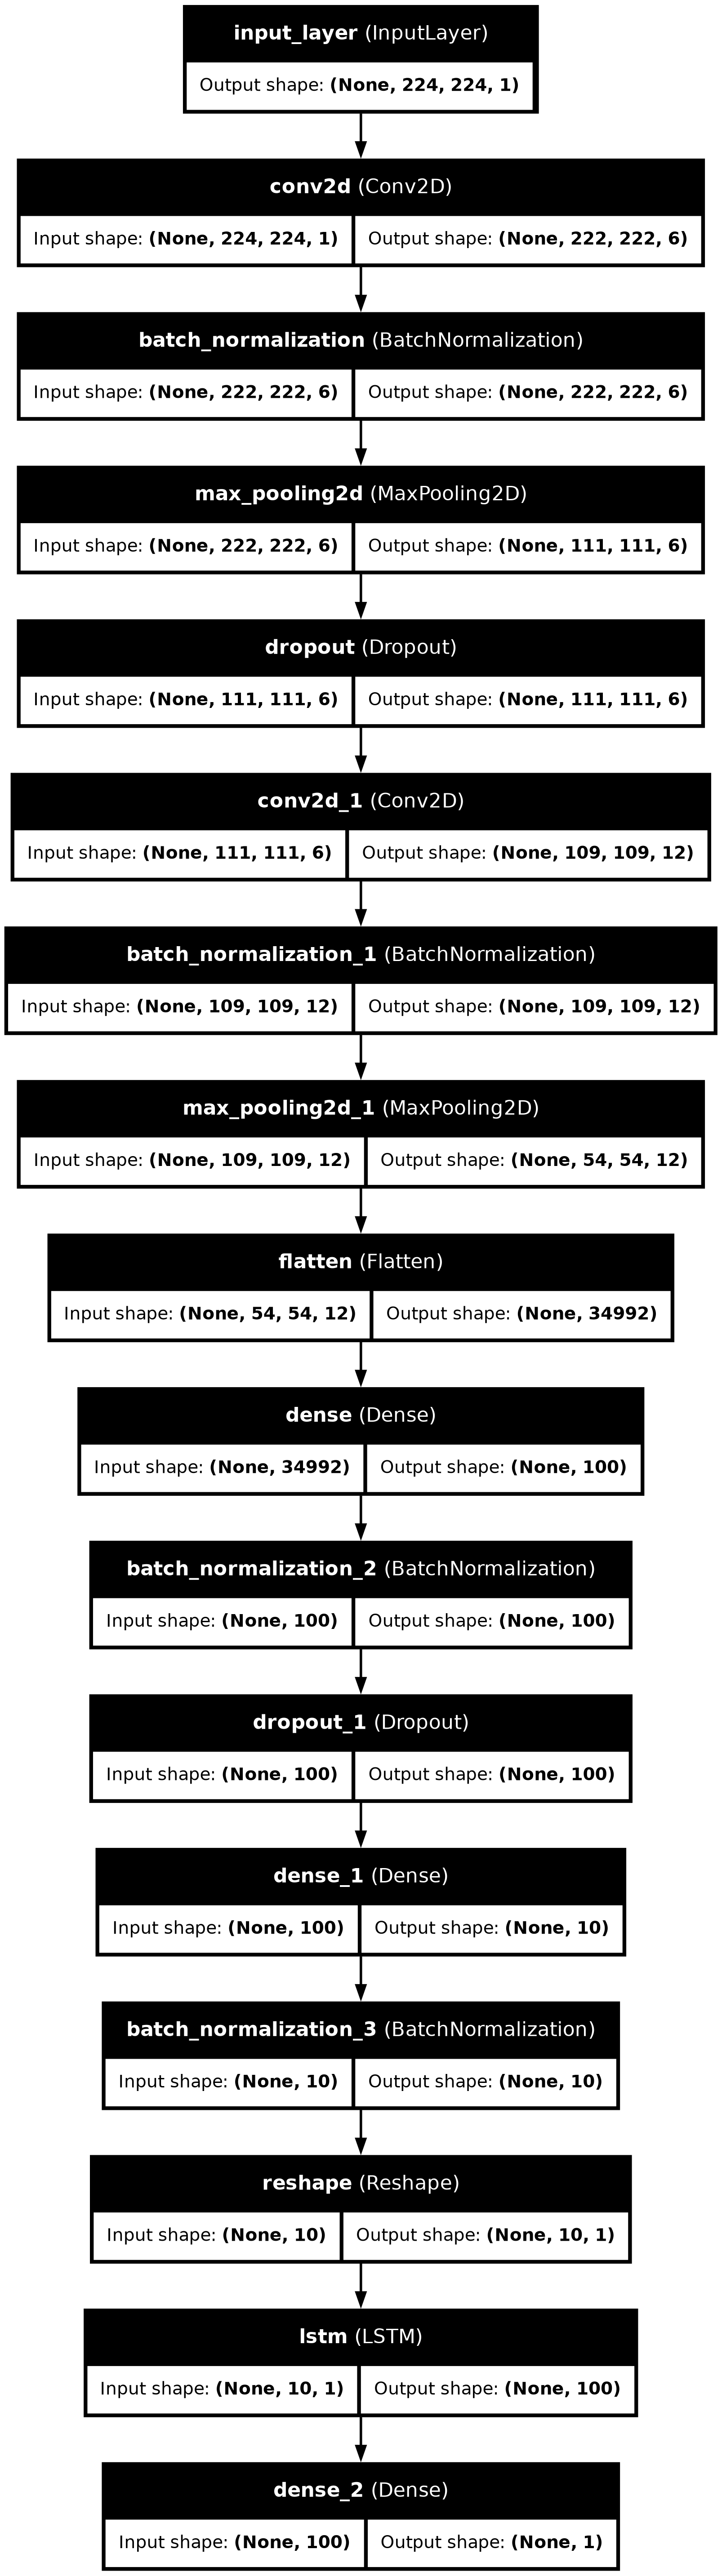

In [5]:
from tensorflow.keras.utils import plot_model
plot_model(hybrid_model, to_file='hybrid_model.png', show_shapes=True, show_layer_names=True)

In [6]:
!pip install visualkeras

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


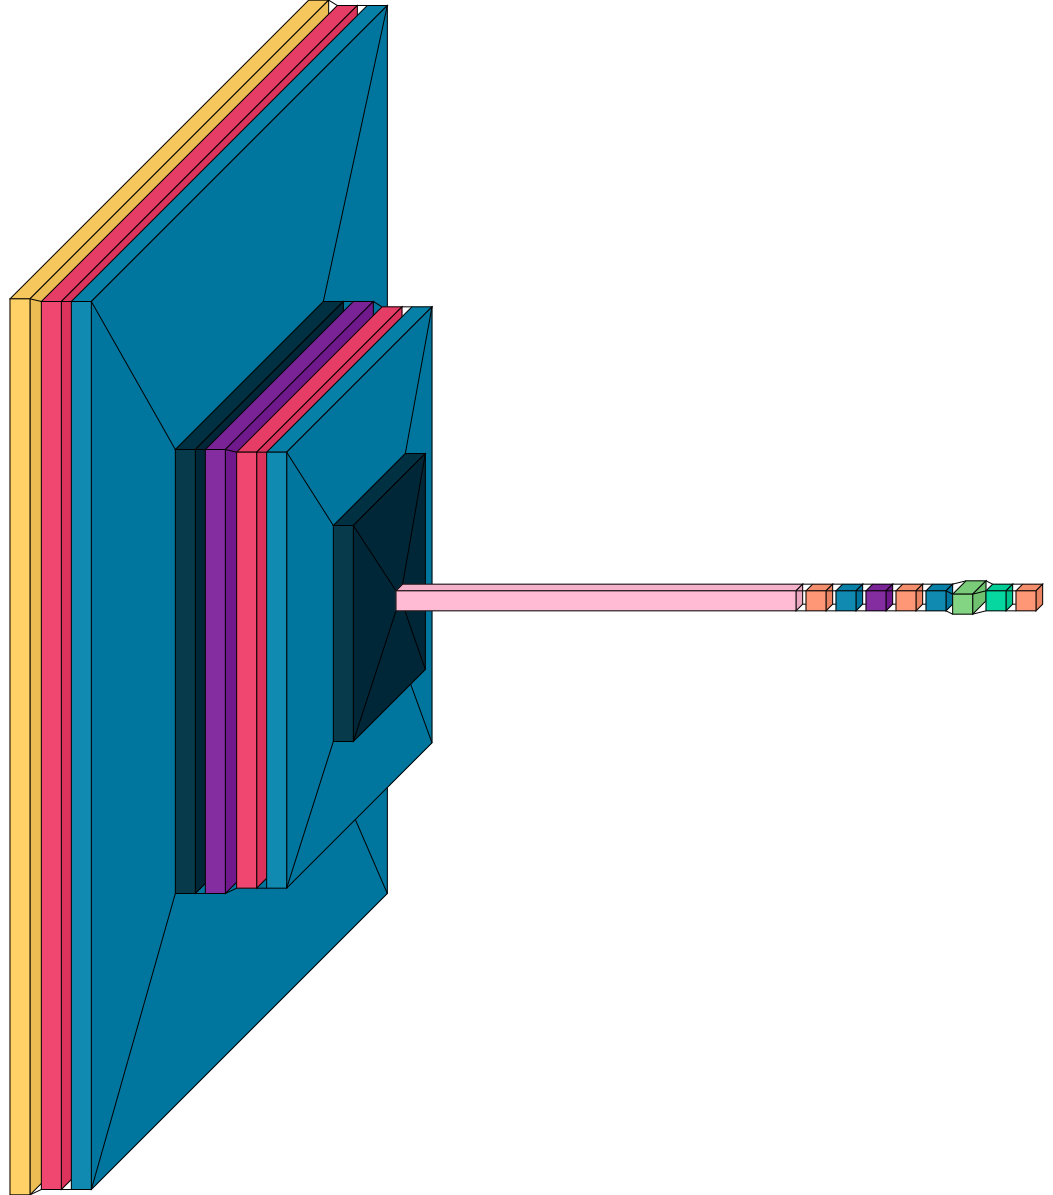

In [7]:
import visualkeras 
visualkeras.layered_view(hybrid_model)

In [26]:
metrics = [TruePositives(name = 'tp'), FalsePositives(name = 'fp'), TrueNegatives(name = 'tn'), FalseNegatives(name = 'fn'),
           BinaryAccuracy(name = 'accuracy'), Precision(name = 'precision'), Recall(name = 'recall'), AUC(name = 'auc') ]

In [29]:
hybrid_model.compile(optimizer = Adam(learning_rate = LEARNING_RATE),
      loss = BinaryCrossentropy(),
      metrics = metrics)

In [30]:
history_thesis = hybrid_model.fit(
    X_train_gray_tf, y_train_tf,
    validation_data=(X_test_gray_tf, y_test_tf),
    epochs=100,
)

Epoch 1/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.6267 - auc: 0.6463 - fn: 1223.6666 - fp: 584.3238 - loss: 0.6425 - precision: 0.5597 - recall: 0.3952 - tn: 2436.2507 - tp: 811.6445 - val_accuracy: 0.6294 - val_auc: 0.6649 - val_fn: 813.0000 - val_fp: 118.0000 - val_loss: 0.6405 - val_precision: 0.6629 - val_recall: 0.2220 - val_tn: 1349.0000 - val_tp: 232.0000
Epoch 2/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.7210 - auc: 0.7801 - fn: 650.7936 - fp: 750.9873 - loss: 0.5506 - precision: 0.6556 - recall: 0.6790 - tn: 2240.9873 - tp: 1413.1174 - val_accuracy: 0.6489 - val_auc: 0.7049 - val_fn: 264.0000 - val_fp: 618.0000 - val_loss: 0.6143 - val_precision: 0.5583 - val_recall: 0.7474 - val_tn: 849.0000 - val_tp: 781.0000
Epoch 3/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.7812 - auc: 0.8497 - fn: 336.1429 - fp: 755.7778 - loss: 0.4529 - precision: 0.6939 - recall: 0.8357 - tn: 2218.7683 - tp: 1745.1968 - val_accuracy: 0.6895 - val_au

# **Model Evaluation**

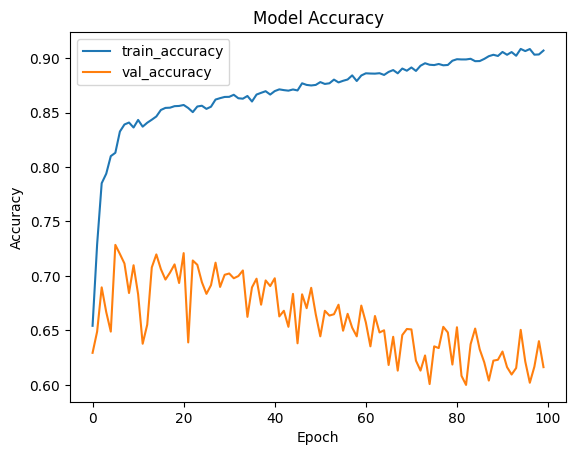

In [31]:
plt.plot(history_thesis.history['accuracy'])
plt.plot(history_thesis.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

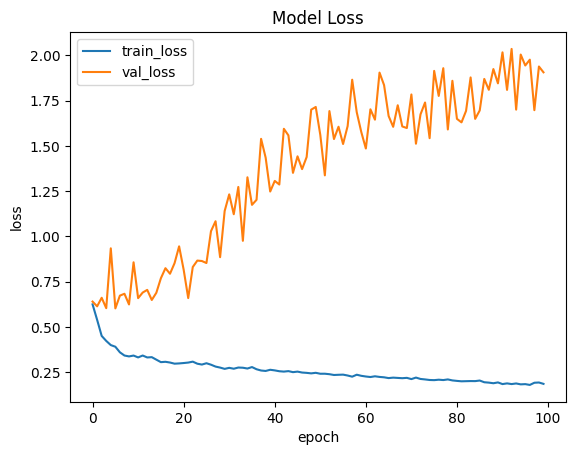

In [32]:
plt.plot(history_thesis.history['loss'])
plt.plot(history_thesis.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

# **LSTM Model**

In [32]:
lstm_model = tf.keras.models.Sequential()

lstm_model.add(tf.keras.layers.LSTM(units=100, input_shape=(224, 224)))

lstm_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 100)            │       130,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,101 (508.21 KB)

 Trainable params: 130,101 (508.21 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
lstm_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
history_lstm = lstm_model.fit( 
    X_train_gray_tf, y_train_tf,
    validation_data=(X_test_gray_tf, y_test_tf),
    epochs=100,
)

Epoch 1/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5932 - loss: 0.6657 - val_accuracy: 0.6262 - val_loss: 0.6479
Epoch 2/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6305 - loss: 0.6399 - val_accuracy: 0.6218 - val_loss: 0.6428
Epoch 3/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6429 - loss: 0.6369 - val_accuracy: 0.6294 - val_loss: 0.6431
Epoch 4/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6296 - loss: 0.6419 - val_accuracy: 0.6222 - val_loss: 0.6519
Epoch 5/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6271 - loss: 0.6386 - val_accuracy: 0.6178 - val_loss: 0.6429
Epoch 6/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6349 - loss: 0.6321 - val_accuracy: 0.6298 - val_loss: 0.6336
Epoch 7/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6342 - loss: 0.6325 - val_accuracy: 0.6338 - val_loss: 0.6367
Epoch 8/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6429 - loss: 0.6301 - 

# **LSTM Model Visualiztion**

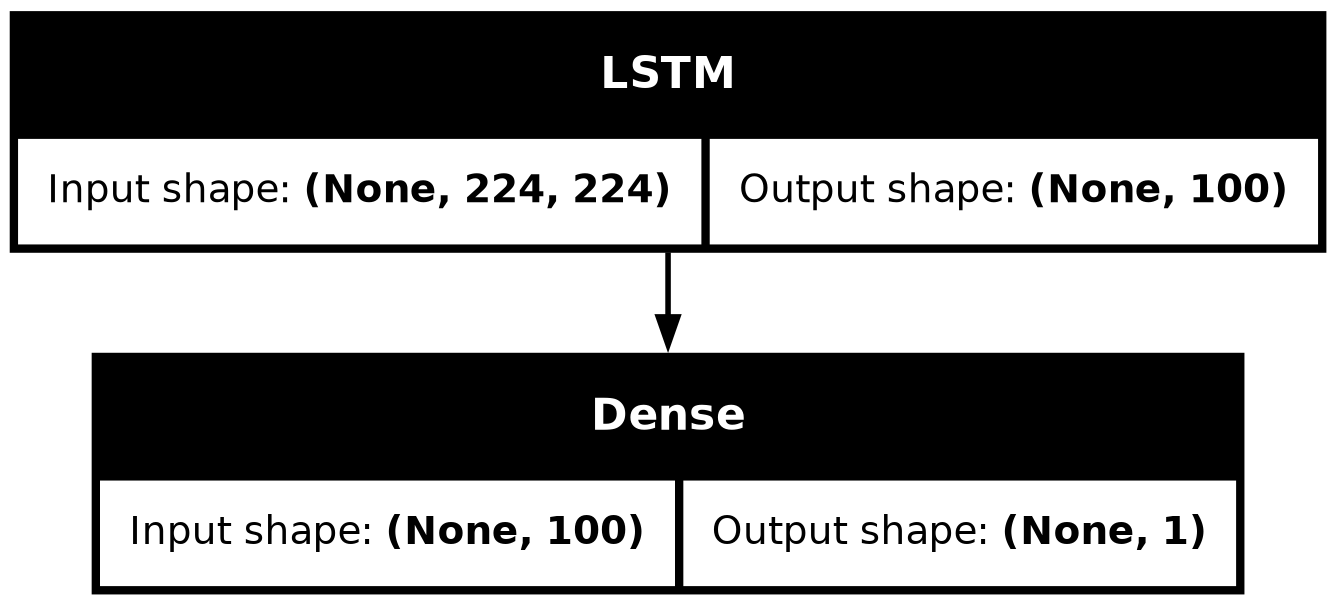

In [35]:
from keras.utils import plot_model
plot_model(lstm_model, to_file="model_architecture.png", show_shapes=True)

# **LSTM Evaluation** 

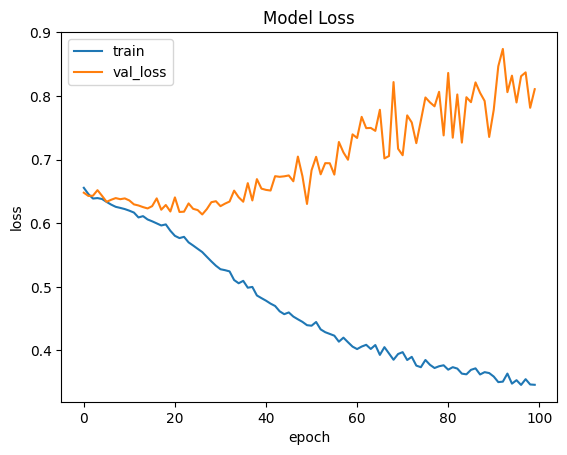

In [42]:
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'])
plt.show()

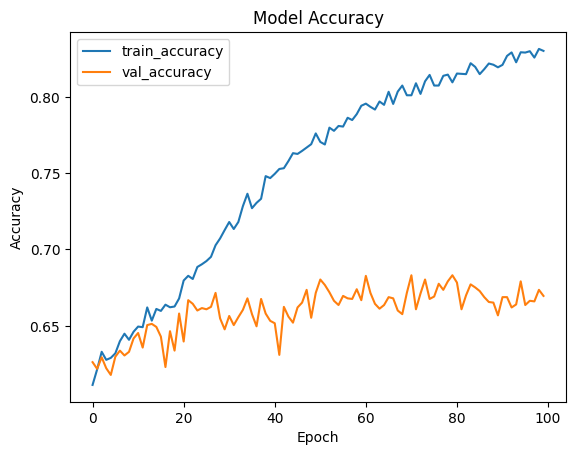

In [43]:
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# **CNN Architecture**

In [36]:
LEARNING_RATE =  0.001
N_EPOCHS = 5
BATCH_SIZE = 128
DROPOUT_RATE = 0.0
IM_SIZE = 224
REGULARIZATION_RATE = 0.0
N_FILTERS = 6
KERNEL_SIZE = 3
N_STRIDES = 1
POOL_SIZE = 2
N_DENSE_1 = 100
N_DENSE_2 = 10

lenet_model_grayscale = Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 1)), 

    Conv2D(filters=N_FILTERS, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D(pool_size=POOL_SIZE, strides=(2, 2)),
    Dropout(rate=DROPOUT_RATE),

    Conv2D(filters=N_FILTERS*2, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D(pool_size=POOL_SIZE, strides=(2, 2)),

    Flatten(),

    Dense(N_DENSE_1, activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate=DROPOUT_RATE),

    Dense(N_DENSE_2, activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),

    Dense(1, activation='sigmoid')
])

lenet_model_grayscale.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 6)    │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 12)   │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 12)   │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 34992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │     3,499,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501,553 (13.36 MB)

 Trainable params: 3,501,297 (13.36 MB)

 Non-trainable params: 256 (1.00 KB)

# **CNN Model Visualization**

In [40]:
pip install visualkeras

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 4.5 MB/s eta 0:00:0000:0100:01m
Note: you may need to restart the kernel to use updated packages.


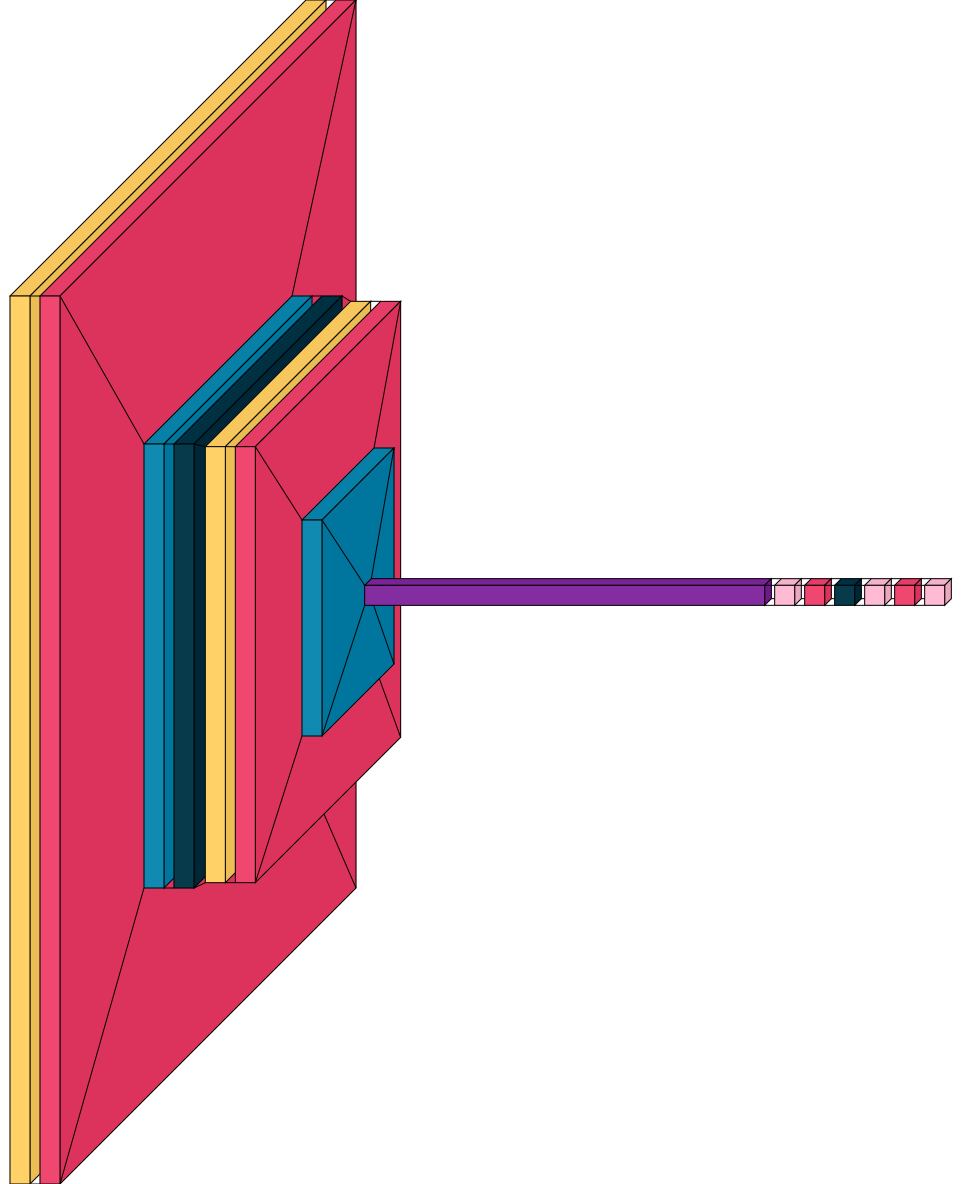

In [41]:
import visualkeras 
visualkeras.layered_view(lenet_model_grayscale)

In [ ]:
# metrics = [TruePositives(name = 'tp'), FalsePositives(name = 'fp'), TrueNegatives(name = 'tn'), FalseNegatives(name = 'fn'),
#            BinaryAccuracy(name = 'accuracy'), Precision(name = 'precision'), Recall(name = 'recall'), AUC(name = 'auc') ]

In [38]:
lenet_model_grayscale.compile(optimizer = Adam(learning_rate = LEARNING_RATE),
      loss = BinaryCrossentropy(),
      metrics=['accuracy'])

In [39]:
history = lenet_model_grayscale.fit(
    X_train_gray_tf, y_train_tf,
    validation_data=(X_test_gray_tf, y_test_tf),
    epochs=100,
)

Epoch 1/100
  7/314 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5823 - loss: 0.8942 

I0000 00:00:1720978889.738578     148 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720978889.769919     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6325 - loss: 0.6886

W0000 00:00:1720978898.786573     151 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


314/314 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.6326 - loss: 0.6884 - val_accuracy: 0.4204 - val_loss: 0.7902
Epoch 2/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7115 - loss: 0.5634 - val_accuracy: 0.6322 - val_loss: 0.6506
Epoch 3/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7483 - loss: 0.5137 - val_accuracy: 0.6529 - val_loss: 0.6330
Epoch 4/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7810 - loss: 0.4599 - val_accuracy: 0.6835 - val_loss: 0.6576
Epoch 5/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8089 - loss: 0.4138 - val_accuracy: 0.6847 - val_loss: 0.6175
Epoch 6/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8178 - loss: 0.3880 - val_accuracy: 0.5924 - val_loss: 0.7520
Epoch 7/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8308 - loss: 0.3595 - val_accuracy: 0.6716 - val_loss: 0.7542
Epoch 8/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8275 - loss: 0.3674 - val_accurac

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(lstm_model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

# **CNN Evaluation**

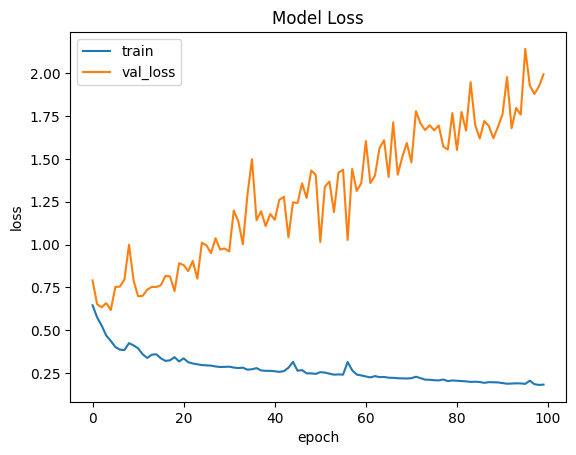

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'])
plt.show()

Loading images:   0%|          | 0/12612 [35:59<?, ?image/s]


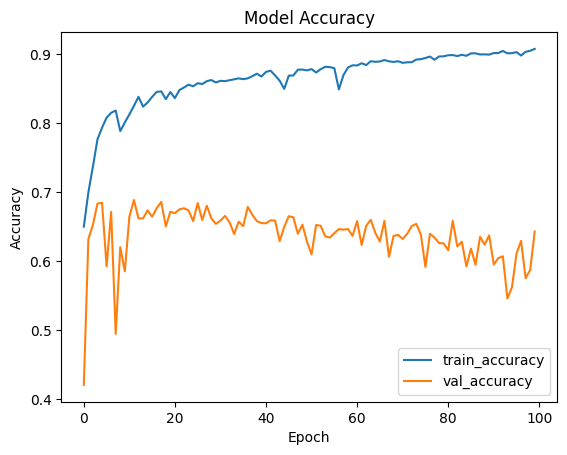

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# **VGG-16**

In [47]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Lambda
from tensorflow.keras.models import Model

In [49]:
def repeat_channels(x):
    return tf.repeat(x, 3, axis=-1)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


inputs = Input(shape=(224, 224, 1))  
x = Lambda(repeat_channels)(inputs)
x = base_model(x, training=False)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

vgg16_model = Model(inputs, outputs)

vgg16_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# VGG16 Model Visualization

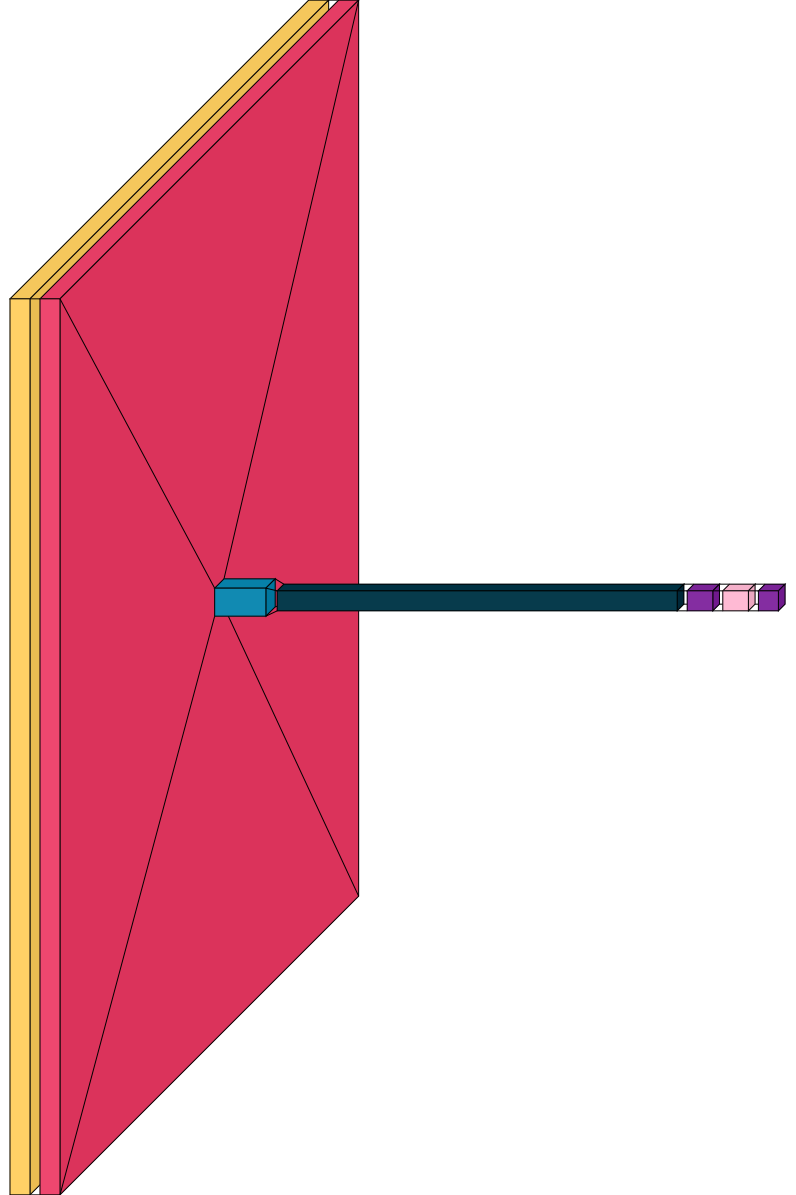

In [52]:
import visualkeras 
visualkeras.layered_view(vgg16_model)

In [50]:
vgg16_model.compile(optimizer = Adam(learning_rate = LEARNING_RATE),
      loss = BinaryCrossentropy(),
      metrics=['accuracy'])

In [53]:
history_vgg16 = vgg16_model.fit(
    X_train_gray_tf, y_train_tf,
    validation_data=(X_test_gray_tf, y_test_tf),
    epochs=100,
)

Epoch 1/100
  1/314 ━━━━━━━━━━━━━━━━━━━━ 2:33:29 29s/step - accuracy: 0.5625 - loss: 0.7520

W0000 00:00:1720980470.732158     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5771 - loss: 0.9502

W0000 00:00:1720980534.712226     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720980535.706779     151 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


314/314 ━━━━━━━━━━━━━━━━━━━━ 120s 290ms/step - accuracy: 0.5772 - loss: 0.9495 - val_accuracy: 0.5840 - val_loss: 0.6427
Epoch 2/100
  1/314 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - accuracy: 0.5938 - loss: 0.6222

W0000 00:00:1720980561.512039     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


314/314 ━━━━━━━━━━━━━━━━━━━━ 48s 152ms/step - accuracy: 0.5927 - loss: 0.6433 - val_accuracy: 0.5840 - val_loss: 0.6411
Epoch 3/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 48s 153ms/step - accuracy: 0.5996 - loss: 0.6265 - val_accuracy: 0.6361 - val_loss: 0.6223
Epoch 4/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 48s 152ms/step - accuracy: 0.6403 - loss: 0.6101 - val_accuracy: 0.6465 - val_loss: 0.6138
Epoch 5/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 48s 153ms/step - accuracy: 0.6389 - loss: 0.6100 - val_accuracy: 0.6401 - val_loss: 0.6188
Epoch 6/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 48s 153ms/step - accuracy: 0.6514 - loss: 0.5937 - val_accuracy: 0.6469 - val_loss: 0.6195
Epoch 7/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 48s 153ms/step - accuracy: 0.6462 - loss: 0.5919 - val_accuracy: 0.6433 - val_loss: 0.6079
Epoch 8/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 48s 154ms/step - accuracy: 0.6729 - loss: 0.5698 - val_accuracy: 0.6628 - val_loss: 0.5966
Epoch 9/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 48s 154ms/step - accuracy: 0.6798 - loss: 0.558

# VGG16 Model Evaluation

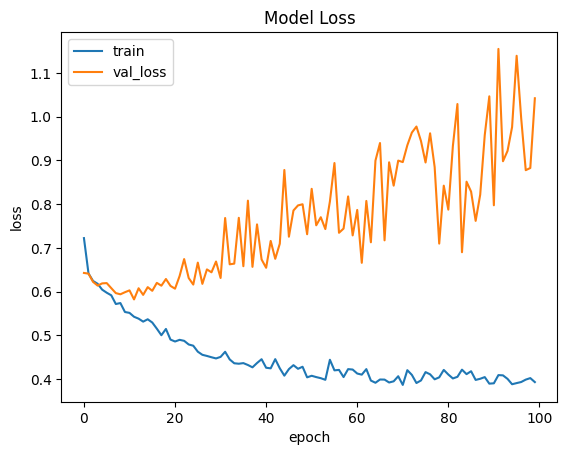

In [54]:
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'])
plt.show()

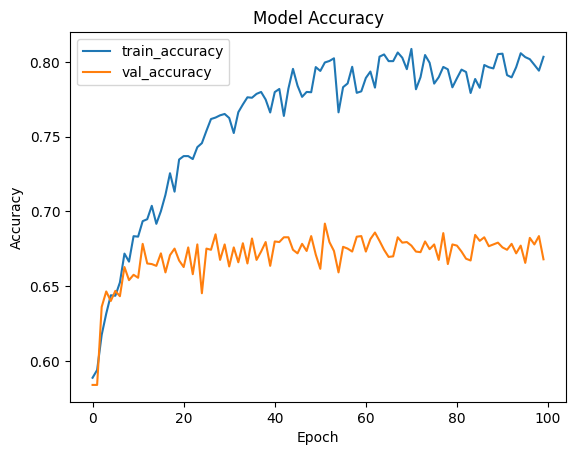

In [55]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# **ResNet50**

In [57]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50

In [58]:
resnet_model = tf.keras.Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),  # Change channels to 1 for grayscale
    pooling='avg',
    classes=1,
    weights='imagenet'
)

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dropout(0.2))  # Optional dropout
resnet_model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [59]:
resnet_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [60]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
resnet_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history_resnet = resnet_model.fit( 
    X_train_tf, y_train_tf,
    validation_data=(X_test_tf, y_test_tf),
    epochs=100,
)

Epoch 1/100
  2/314 ━━━━━━━━━━━━━━━━━━━━ 35s 114ms/step - accuracy: 0.5000 - loss: 1.0108  

W0000 00:00:1720985659.639576     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5593 - loss: 0.7222

W0000 00:00:1720985694.730748     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# **ROC|AUC**

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_pred_prob is the predicted probabilities for the positive class
# and y_true are the true labels (0 or 1)
y_pred_prob = lenet_model_grayscale.predict(X_test_gray_tf)
y_true = y_test  # Replace with your true labels

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, LSTM, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2

In [ ]:
# Define your LeNet model for grayscale images (ConvNet part)
IM_SIZE = 224
N_FILTERS = 6
KERNEL_SIZE = 3
N_STRIDES = 1
POOL_SIZE = 2
N_DENSE_1 = 100
N_DENSE_2 = 10
DROPOUT_RATE = 0.0
REGULARIZATION_RATE = 0.0

input_layer = Input(shape=(IM_SIZE, IM_SIZE, 1))

x = Conv2D(filters=N_FILTERS, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE))(input_layer)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=POOL_SIZE, strides=(2, 2))(x)
x = Dropout(rate=DROPOUT_RATE)(x)

x = Conv2D(filters=N_FILTERS*2, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE))(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=POOL_SIZE, strides=(2, 2))(x)

x = Flatten()(x)

x = Dense(N_DENSE_1, activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE))(x)
x = BatchNormalization()(x)
x = Dropout(rate=DROPOUT_RATE)(x)

x = Dense(N_DENSE_2, activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE))(x)
x = BatchNormalization()(x)

# Reshape the output to match the LSTM input shape
x = Reshape((N_DENSE_2, 1))(x)

# LSTM part
lstm_output = LSTM(units=100)(x)

output_layer = Dense(1, activation='sigmoid')(lstm_output)

# Create the hybrid model
hybrid_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Print model summary to verify the architecture
hybrid_model.summary()


In [ ]:
input_img = Input(shape=(IM_SIZE, IM_SIZE, 1), name='input_img')

x = Conv2D(filters=N_FILTERS, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE))(input_img)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=POOL_SIZE, strides=(2, 2))(x)
x = Dropout(rate=DROPOUT_RATE)(x)

x = Conv2D(filters=N_FILTERS*2, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE))(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=POOL_SIZE, strides=(2, 2))(x)

x = Flatten()(x)

x = Dense(N_DENSE_1, activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE))(x)
x = BatchNormalization()(x)
x = Dropout(rate=DROPOUT_RATE)(x)

x = Dense(N_DENSE_2, activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE))(x)
x = BatchNormalization()(x)

x = Reshape((N_DENSE_2, 1))(x)

lstm_out = LSTM(units=100)(x)

output = Dense(1, activation='sigmoid')(lstm_out)

hybrid_model = Model(inputs=input_img, outputs=output)
hybrid_model.summary()